# HANC with a Welfare State

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize
from consav.misc import elapsed

import sys
import os
original_stdout = sys.stdout

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCWelfareModel import HANCWelfareModelClass
from steady_state import obj_ss

## Model without a Governement

I import the model and draw the DAG

In [2]:
model = HANCWelfareModelClass(name='baseline')
par = model.par
ss = model.ss

production_firm: [K,L] -> [rK,w,Y]
mutual_fund: [K,rK] -> [A,r]
government: [L,w,tau,chi] -> [B,G,Lg,wt]
hh: [chi,r,tau,w,wt] -> [A_hh,C_hh,ELL_hh,L_hh,INC_hh,U_hh,S_hh]
market_clearing: [A,A_hh,L,Lg,L_hh,Y,C_hh,K,G,w,tau,chi] -> [I,clearing_A,clearing_L,clearing_Y,clearing_G]


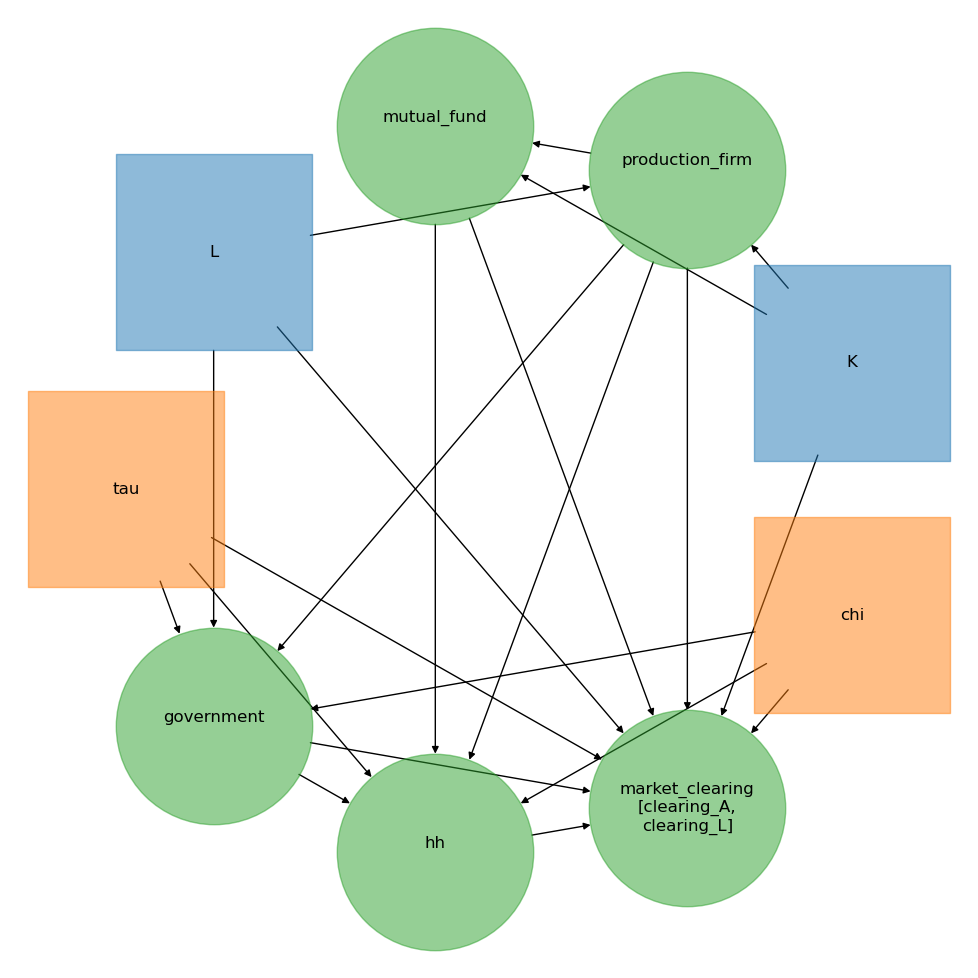

In [3]:
model.info(only_blocks=True)
model.draw_DAG()

I set all the steady values for the household problem manually at ad hoc values and now solve and simulate:

In [4]:
ss.r = 0.02*(1-0.1)
ss.wt = 1.00*(1-0.3)
ss.w = ss.wt/(1-par.tau_ss)
ss.tau = par.tau_ss
ss.chi = par.chi_ss

In [5]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 0.2 secs [345 iterations]
household problem in ss simulated in 1.0 secs [399 iterations]


And check whether the results make sort of sense:

In [6]:
print(f'{model.ss.A_hh = :.2f}')
print(f'{model.ss.L_hh = :.2f}')
print(f'{model.ss.C_hh = :.2f}')

model.ss.A_hh = 2.03
model.ss.L_hh = 1.06
model.ss.C_hh = 0.78


The results seem to make sense and thus I will now solve for the steady state in the model with no Gorvernment.

In [7]:
#setting values to zero to remove government
model.par.tau_ss = 0.0
model.par.chi_ss = 0.0

#simulating the steady state
model.find_ss(do_print=True)

starting at [3.8624]

 message: The solution converged.
 success: True
  status: 1
     fun: 6.981082378842984e-13
       x: [ 3.673e+00]
    nfev: 8
    fjac: [[-1.000e+00]]
       r: [-8.480e+00]
     qtf: [-6.223e-08]

steady state found in 2.8 secs
ss.K =  3.389
ss.A_hh =  3.389
ss.Y =  1.363
ss.C_hh =  1.024
ss.G =  0.000
ss.I =  0.339
ss.L =  0.923
ss.Lg =  0.000
ss.r =  0.021
ss.w =  1.034
ss.wt =  1.034
ss.clearing_A = 6.98e-13
ss.clearing_L = 0.00e+00
ss.clearing_Y = 1.29e-10
ss.clearing_G = 0.00e+00


I see we find a steady state where we see there is no government (ss.G=ss.Lg=0). Testing the stationary equilibrium I find

In [8]:
model.test_path()

shocks: tau chi 
unknowns: K L 

blocks.production_firm
 rK               0.0e+00
 w                0.0e+00
 Y                0.0e+00
blocks.mutual_fund
 A                0.0e+00
 r                0.0e+00
blocks.government
 B                0.0e+00
 G                0.0e+00
 Lg               0.0e+00
 wt               0.0e+00
hh
 A_hh             2.7e-09
 C_hh             7.7e-11
 ELL_hh           1.2e-10
 L_hh             1.0e-10
 INC_hh           4.9e-11
 U_hh             1.9e-10
 S_hh             0.0e+00
blocks.market_clearing
 I                0.0e+00
 clearing_A       2.7e-09 [target]
 clearing_L       1.0e-10 [target]
 clearing_Y       7.7e-11
 clearing_G       0.0e+00


note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 0.3 secs
household problem simulated along transition in 0.0 secs



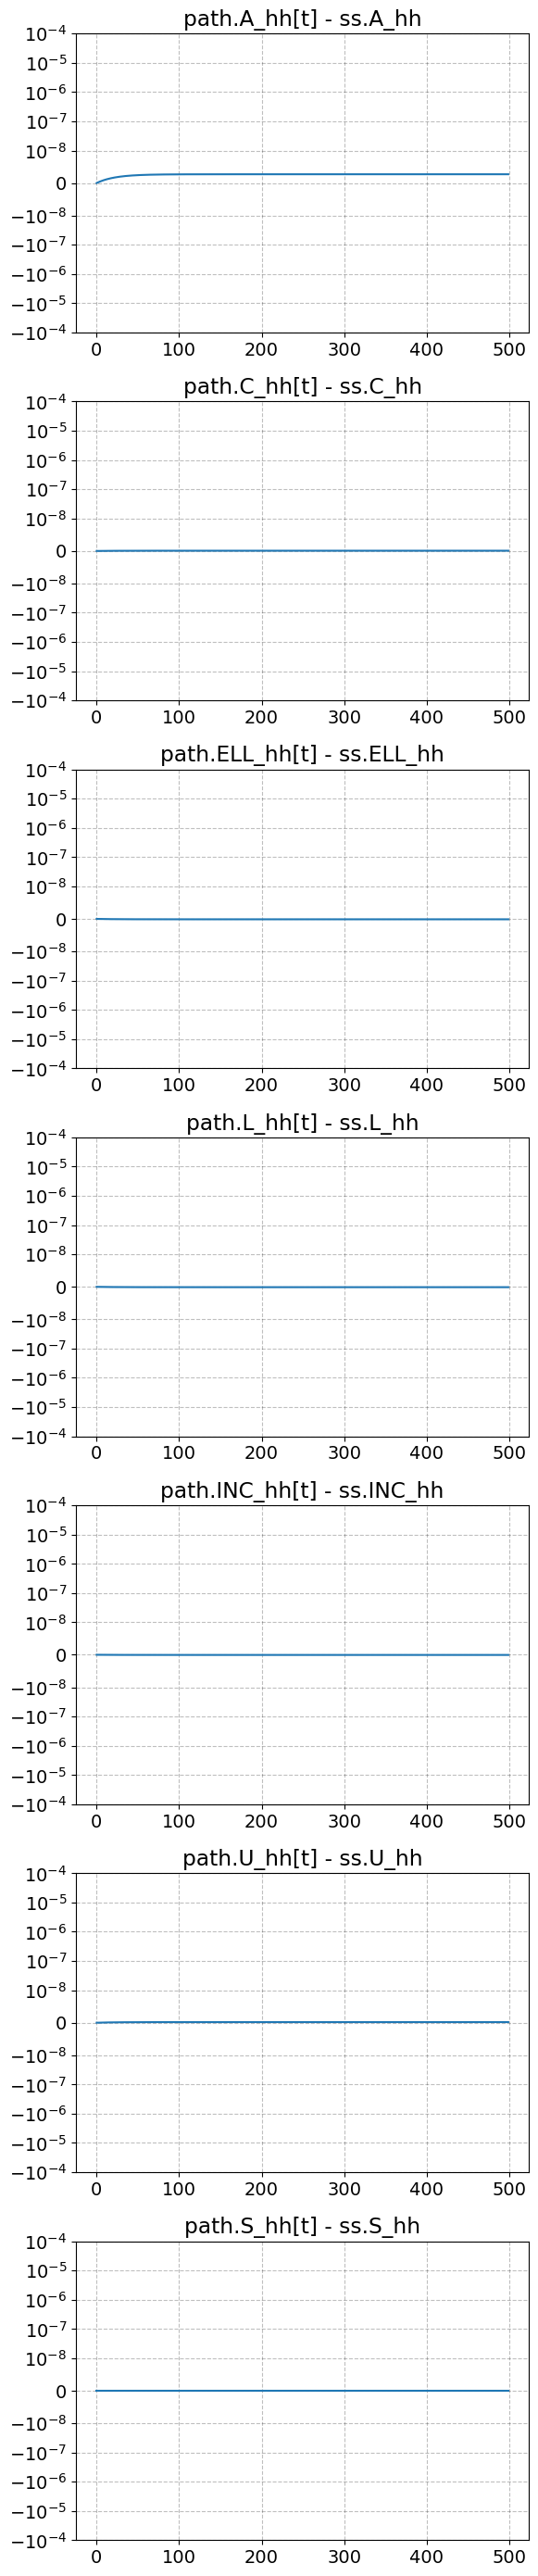

In [9]:
model.test_hh_path()

And we see that the steady state is indeed a stationary equilibrium.

I can therefore calculate the expected utility of the household in the steady state:

In [10]:
util_no_govern = np.sum([par.beta**t * ((np.sum((ss.u+(ss.G+par.S)**(1-par.omega)/(1-par.omega)) * ss.D / (np.sum(ss.D))))) for t in range(par.T)])
print(f'{util_no_govern = :.2f}')

util_no_govern = -2500000037.03


We see that the expected utility is very negavtive in the case of no Governement in the model. This is because the household is not insured against the risk of unemployment and thus the household is very exposed to the risk of unemployment. This is also why the household chooses to work a lot in the steady state.

## Optimal welfare policy with only taxes on labour income

I start by creating a new instance of our baseline model and the use the optimize_social_welfare function utilizing a scalar minimizer to find the optimal tax rate on labour income with an initial guess of 0.5:

In [11]:
modelI = model.copy()

In [12]:
optI = modelI.optimize_social_welfare(tau_guess=0.5,do_print=True)

Optimal taxes found in 48.2 secs
Optimal wage tax: ss.tau = 0.6551
Optimal lump sum transfer: ss.chi = 0.0000

Steady state values with optimized tax levels
ss.K =  2.897
ss.A_hh =  2.897
ss.Y =  1.221
ss.C_hh =  0.517
ss.G =  0.415
ss.I =  0.290
ss.L =  0.843
ss.Lg =  0.415
ss.r =  0.026
ss.w =  1.014
ss.wt =  0.350
ss.clearing_A = -1.95e-14
ss.clearing_L = 0.00e+00
ss.clearing_Y = 1.14e-10
ss.clearing_G = 0.00e+00


Thus I find the optimal tax on labour as $\tau=65.51\%$.

The Goverment spending output ratio can therefore be calculated as:

In [13]:
print(f'{modelI.ss.G/modelI.ss.Y = :.4f}')

modelI.ss.G/modelI.ss.Y = 0.3398


## Optimal welfare policy with taxes on labour income and lumpsum transfers

I again create a new instance of the baseline model

In [14]:
modelII = model.copy()

I run the optimize_social_welfare function now guessing on both $\tau$ and $\chi$ using the previous results as initial guesses:

In [15]:
optII = modelII.optimize_social_welfare(tau_guess=optI[0],chi_guess=optI[1],do_print=True)

Optimal taxes found in 4.0 mins 50 secs
Optimal wage tax: ss.tau = 0.4766
Optimal lump sum transfer: ss.chi = -0.2182

Steady state values with optimized tax levels
ss.K =  3.479
ss.A_hh =  3.479
ss.Y =  1.399
ss.C_hh =  0.606
ss.G =  0.444
ss.I =  0.348
ss.L =  0.946
ss.Lg =  0.444
ss.r =  0.021
ss.w =  1.034
ss.wt =  0.541
ss.clearing_A = 1.08e-13
ss.clearing_L = 0.00e+00
ss.clearing_Y = 1.32e-10
ss.clearing_G = 0.00e+00


Thus the optimal taxrate in this case is $\tau = 47.66\%$ and the optimal lumpsum transfer is $\chi = -0.2181$ implying a lumpsum tax.

The Goverment spending output ratio can therefore be calculated as:

In [16]:
ratio = modelII.ss.G/modelII.ss.Y
print(f'G_ss/Y_ss = {ratio :.4f}')

G_ss/Y_ss = 0.3177


## Model with increased TFP and Government

I once again create a new instance of the model and repeat the same steps as before but with $\Gamma^Y = 1.1$:

In [17]:
modelIII = model.copy()

modelIII.par.Gamma_Y = 1.1

Again I run the optimize_social_welfare function guessing on both $\tau$ and $\chi$ using the previous results as initial guesses:

In [18]:
optIII = modelIII.optimize_social_welfare(tau_guess=optII[0],chi_guess=optII[1],do_print=True)

Optimal taxes found in 2.0 mins 29 secs
Optimal wage tax: ss.tau = 0.4815
Optimal lump sum transfer: ss.chi = -0.2476

Steady state values with optimized tax levels
ss.K =  3.731
ss.A_hh =  3.731
ss.Y =  1.495
ss.C_hh =  0.657
ss.G =  0.465
ss.I =  0.373
ss.L =  0.882
ss.Lg =  0.465
ss.r =  0.020
ss.w =  1.187
ss.wt =  0.615
ss.clearing_A = 2.22e-15
ss.clearing_L = 0.00e+00
ss.clearing_Y = 1.45e-10
ss.clearing_G = 0.00e+00


In [19]:
ratio = modelIII.ss.G/modelIII.ss.Y
print(f'G_ss/Y_ss = {ratio :.4f}')

G_ss/Y_ss = 0.3112


Lastly I plot the cummulative savings for each model evaluated:

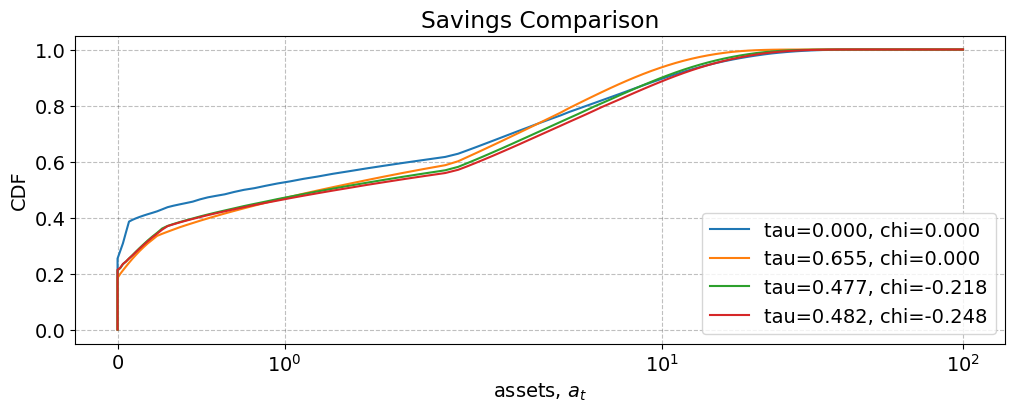

In [20]:
def plot_model_results(models):
    fig, ax = plt.subplots(figsize=(12,4), dpi=100)

    # b. assets
    ax.set_title('Savings Comparison')

    for model in models:
        y = np.insert(np.cumsum(np.sum(model.ss.D, axis=(0,1))), 0, 0.0)
        label = f'tau={model.ss.tau:.3f}, chi={model.ss.chi:.3f}'
        ax.plot(np.insert(model.par.a_grid, 0, model.par.a_grid[0]), y/y[-1], label=label)

    ax.set_xlabel('assets, $a_{t}$')
    ax.set_ylabel('CDF')
    ax.set_xscale('symlog')
    ax.legend(loc='lower right')

# Call the function with all models
plot_model_results([model, modelI, modelII, modelIII])

## Transition to new steady state

To find the transition to the new steady state I first compute the jabobian of the model:

In [21]:
modelIII.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for chi             in 0.5 secs
curly_Y and curly_D calculated for r               in 0.4 secs
curly_Y and curly_D calculated for tau             in 0.4 secs
curly_Y and curly_D calculated for w               in 0.4 secs
curly_Y and curly_D calculated for wt              in 0.5 secs
curly_E calculated in 0.8 secs
builiding blocks combined in 2.5 secs
household Jacobian computed in 5.6 secs

full Jacobians:
full Jacobian to unknowns computed in 1.2 secs [in evaluate_blocks(): 1.0 secs]
full Jacobian to shocks computed in 1.1 secs [in evaluate_blocks(): 0.9 secs]


Next I define the initial values for where the economy starts:

In [22]:
ini = vars(modelII.ss)

To evaluate how the tranistion should be I will test out 4 different scenarios:
Common for all scenarios is that the governement observes the change in TFP in period 0 and will not adjust the tax rate and lumpsum transfer to the optimal values in period before period 1.


- In the baseline scenario the government jumps straight to the optimal tax rate and lumpsum transfer in period 1.
- In the second scenario the government will adjust the tax rate linearly from the initial tax rate to the optimal tax rate in over an unspecified number of periods.
- In the third scenario the government will reduce the gap between the initial tax rate and the optimal tax rate by an unkonwn fraction in each period thereby the change in the tax rate will be decreasing over time.
- In the fourth scenario the government will increase the taxes from the initial tax rate to the optimal tax rate by an unknown fraction in each period thereby the change in the tax rate will be increasing over time.

I start by evaluating the baseline scenario:

In [23]:
# Creating arrays for the shocks
dtau = np.zeros(par.T)
dchi = np.zeros(par.T)

# Setting shock values
dtau[0:1] = modelII.ss.tau - modelIII.ss.tau
dchi[0:1] = modelII.ss.chi - modelIII.ss.chi

# Creating dictionary for the shocks
shocks = {'dtau': dtau,
          'dchi': dchi}

modelIII.find_transition_path(shocks=shocks,ini=ini,do_print=False)
v_shock = np.sum([modelIII.par.beta**t * np.sum((modelIII.path.u[t]+(modelIII.path.G[t]+modelIII.par.S)**(1-modelIII.par.omega)/(1-modelIII.par.omega)) * modelIII.path.D[t] / (np.sum(modelIII.path.D[t]))) for t in range(modelIII.par.T)])
print(v_shock)

clearing_Y: terminal value is   0.46524929, but ss value is   0.00000000
-129.19583970048808


Next I define an integer minimizer to find the optimal number of periods it takes for the economy to reach the new steady state in the second scenario and evaluate the results:

In [24]:
def obj_lin(model,len):
    #a. Creating arrays for the shocks
    dtau = np.zeros(par.T)
    dchi = np.zeros(par.T)

    #b. Assuming government cannot adjust the tax rate in the first period but must observe the shock
    dtau[0:1] = modelII.ss.tau - model.ss.tau
    dchi[0:1] = modelII.ss.chi - model.ss.chi

    #c. Setting the shock values for the remaining periods
    for i in range(1,len+1):
        dtau[i] = dtau[i-1] + (model.ss.tau-modelII.ss.tau)/len
        dchi[i] = dchi[i-1] + (model.ss.chi-modelII.ss.chi)/len

    #d. Creating dictionary for the shocks
    shocks = {'dtau': dtau,
            'dchi': dchi}        
    
    #e. finding the transition path
    sys.stdout = open(os.devnull, 'w')
    model.find_transition_path(shocks=shocks,ini=ini,do_print=False)
    sys.stdout = original_stdout
    
    #f. Calculating the expected utility
    val = - np.sum([model.par.beta**t * np.sum((model.path.u[t]+(model.path.G[t]+model.par.S)**(1-model.par.omega)/(1-model.par.omega)) * model.path.D[t] / (np.sum(model.path.D[t]))) for t in range(model.par.T)])
    
    return val

def int_minimize(model,max_int, step_size=10,do_print=False,print_results=True):
    
    if do_print:
        print_results = True
    t0 = time.time()
    
    # Rough search
    best_x = 0
    if do_print:
        print(f'Starting in x = {best_x}...', end='')
    best_val = obj_lin(model,best_x)
    if do_print:
        print(f'Value = {best_val:.5f}')
    for x in range(step_size, max_int + 1, step_size):
        if do_print:
            print(f'Checking x = {x}...', end='')
        val = obj_lin(model,x)
        if do_print:
            print(f'Value = {val:.5f}')

        if val < best_val:
            best_x = x
            best_val = val

    # Fine search
    start_x = max(0, best_x - step_size + 1)
    end_x = min(max_int, best_x + step_size - 1)
    if do_print:
        print(f'{best_x} Identified as best in rough search. Starting fine search from {start_x} to {end_x}...')
    for x in range(start_x, end_x + 1):
        if do_print:
            print(f'Checking x = {x}...', end='')
        val = obj_lin(model,x)
        if do_print:
            print(f'Value = {val:.5f}')
        if val < best_val:
            best_x = x
            best_val = val
    
    if print_results:
        print(f'Best x = {best_x} with expected utility of = {-best_val:.5f}')
        print(f'Found in: {elapsed(t0)}')
    return best_x, best_val

In [25]:
modelIIIa = modelIII.copy()
opt_lin = int_minimize(modelIIIa,100, step_size=10,print_results=True)

Best x = 20 with expected utility of = -129.08819
Found in: 1.0 mins 56 secs


For the third ans fourth scenario I define an objective function and use a numerical optimizer to find the optimal fraction of the gap that should be closed in each period or the optimal increase in taxes in each period:

In [26]:
def obj_nonlin_decrease(decr_tau,decr_chi,model):
    #a. Creating arrays for the shocks
    dtau = np.zeros(par.T)
    dchi = np.zeros(par.T)

    #b. Assuming government cannot adjust the tax rate in the first period but must observe the shock
    dtau[0:1] = modelII.ss.tau - model.ss.tau
    dchi[0:1] = modelII.ss.chi - model.ss.chi
    
    #c. Setting the shock values for the remaining periods
    for i in range(1,par.T):
        dtau[i] = dtau[i-1]*decr_tau
        dchi[i] = dchi[i-1]*decr_chi
    
    #d. Creating dictionary for the shocks
    shocks = {'dtau': dtau,
            'dchi': dchi}        
    
    #e. finding the transition path
    sys.stdout = open(os.devnull, 'w')
    model.find_transition_path(shocks=shocks,ini=ini,do_print=False)
    sys.stdout = original_stdout

    #f. Calculating the expected utility
    val = - np.sum([model.par.beta**t * np.sum((model.path.u[t]+(model.path.G[t]+model.par.S)**(1-model.par.omega)/(1-model.par.omega)) * model.path.D[t] / (np.sum(model.path.D[t]))) for t in range(model.par.T)])
    return val

In [27]:
modelIIIb = modelIII.copy()
opt_nonlin_decrease = optimize.minimize(lambda x: obj_nonlin_decrease(x[0],x[1],modelIIIb), x0=[0.93,0.93], bounds=((0.0,1.0),(0.0,1.0)), method='L-BFGS-B')
print(f'Decrease dtau each period = {(1-opt_nonlin_decrease.x[0])*100:.5f}%')
print(f'Decrease dchi each period = {(1-opt_nonlin_decrease.x[1])*100:.5f}%')
print(f'Expected utility = {-opt_nonlin_decrease.fun:.5f}')

Decrease dtau each period = 10.76611%
Decrease dchi each period = 7.88065%
Expected utility = -129.09972


In [28]:
def obj_nonlin_increase(incr_tau,incr_chi,model):
    #a. Creating arrays for the shocks
    dtau = np.zeros(par.T)
    dchi = np.zeros(par.T)

    #b. Assuming government cannot adjust the tax rate in the first period but must observe the shock
    dtau[0:1] = modelII.ss.tau - model.ss.tau
    dchi[0:1] = modelII.ss.chi - model.ss.chi

    #c. Setting the shock values for the remaining periods
    for i in range(1,par.T):
        if np.sign(dtau[i-1]) == np.sign((model.ss.tau+dtau[i-1])*incr_tau - model.ss.tau):
            dtau[i] = (model.ss.tau+dtau[i-1])*incr_tau - model.ss.tau
        
        if np.sign(dchi[i-1]) == np.sign((model.ss.chi+dchi[i-1])*incr_chi - model.ss.chi):
            dchi[i] = (model.ss.chi+dchi[i-1])*incr_chi - model.ss.chi
    
    #d. Creating dictionary for the shocks
    shocks = {'dtau': dtau,
            'dchi': dchi}        
    
    #e. finding the transition path
    sys.stdout = open(os.devnull, 'w')
    model.find_transition_path(shocks=shocks,ini=ini,do_print=False)
    sys.stdout = original_stdout
    
    #f. Calculating the expected utility
    val = - np.sum([model.par.beta**t * np.sum((model.path.u[t]+(model.path.G[t]+model.par.S)**(1-model.par.omega)/(1-model.par.omega)) * model.path.D[t] / (np.sum(model.path.D[t]))) for t in range(model.par.T)])
    
    return val

In [29]:
modelIIIc = modelIII.copy()
opt_nonlin_increase = optimize.minimize(lambda x: obj_nonlin_increase(x[0],x[1],modelIIIc), x0=(1.0,1.0), bounds=((1.0,modelIIIc.ss.tau/modelII.ss.tau),(1.0,modelIIIc.ss.chi/modelII.ss.chi)),  method='Nelder-Mead')
print(f'Increase tau each period = {(opt_nonlin_increase.x[0]-1)*100:.5f}%')
print(f'Decrease chi each period = {(opt_nonlin_increase.x[1]-1)*100:.5f}%')
print(f'Expected utility = {-opt_nonlin_increase.fun:.5f}')

Increase tau each period = 0.06207%
Decrease chi each period = 0.59409%
Expected utility = -129.08742


I now evaluate the three scenarios in the optimum and plot the IRFs:

### shocks ###


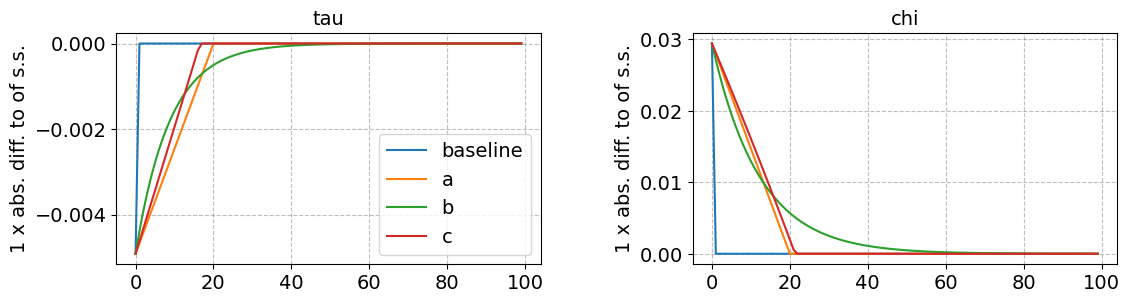


### varnames ###


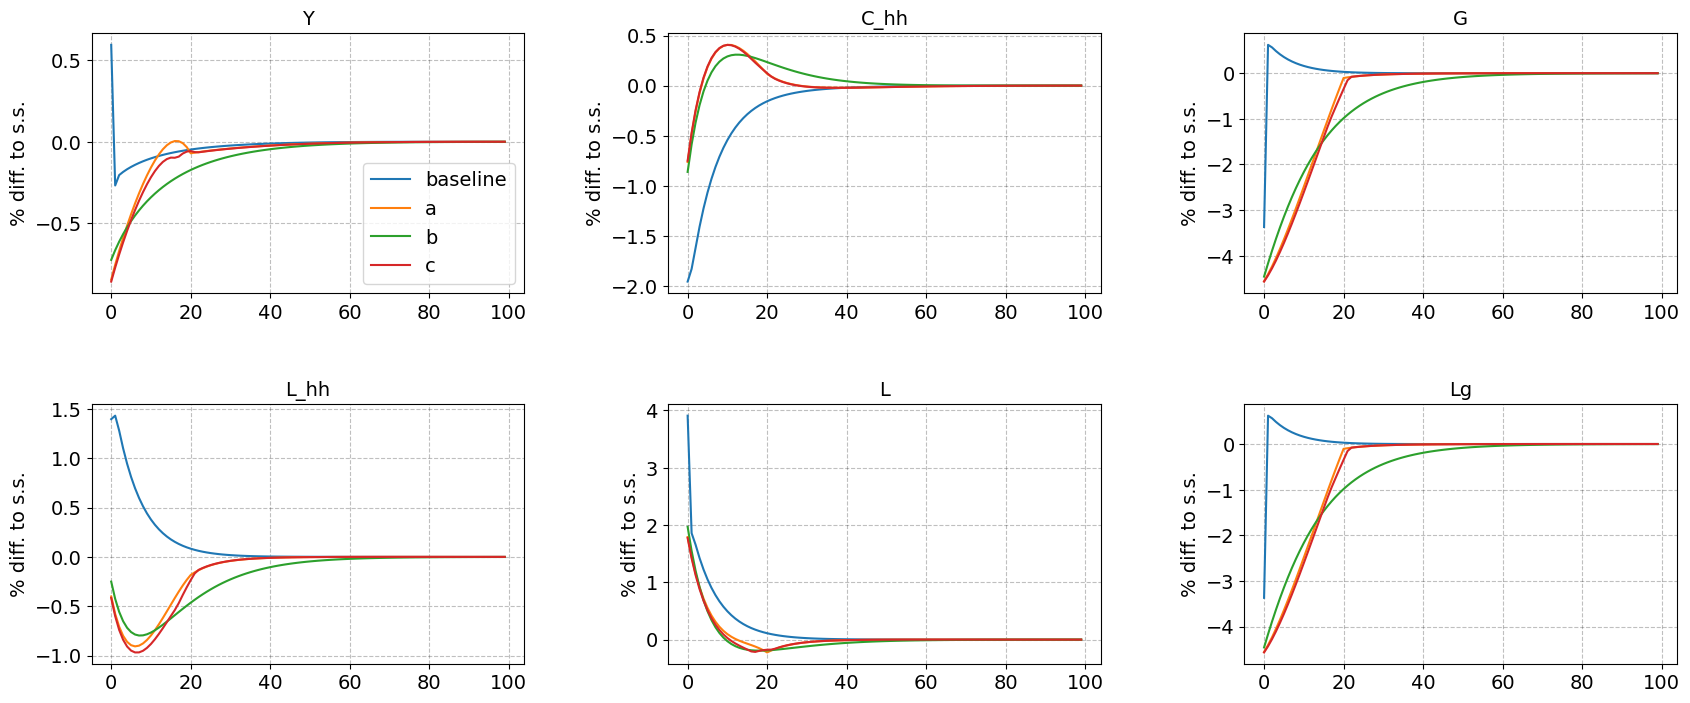


### tagets ###


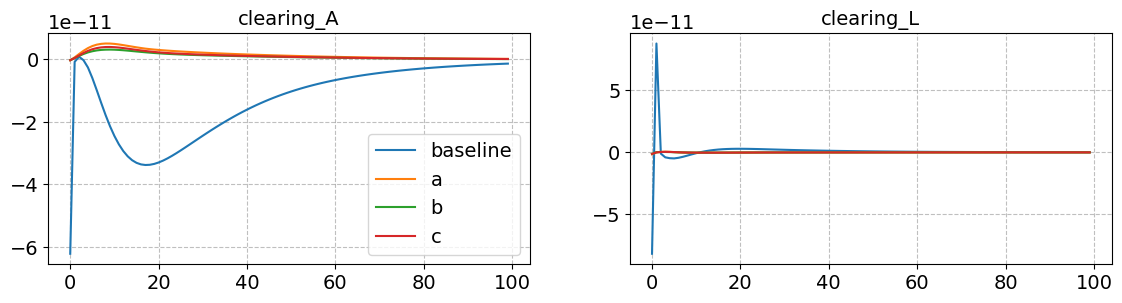

In [30]:
obj_lin(modelIIIa,opt_lin[0])
obj_nonlin_decrease(opt_nonlin_decrease.x[0],opt_nonlin_decrease.x[1],modelIIIb)
obj_nonlin_increase(opt_nonlin_increase.x[0],opt_nonlin_increase.x[1],modelIIIc)
paths = ['Y','C_hh','G','L_hh','L','Lg']
modelIII.compare_IRFs(models=[modelIII,modelIIIa,modelIIIb,modelIIIc],labels=['baseline','a','b','c'],varnames=paths,ncols=3,T_max=100,abs_diff=['tau','chi'],filename='figures/IRFs')

We see that options 2 and 4 have very similar results both outperforming the other scenarios.

In [31]:
modelIIIc.path.chi

array([[-0.2182118 ],
       [-0.21950818],
       [-0.22081227],
       [-0.2221241 ],
       [-0.22344373],
       [-0.22477119],
       [-0.22610655],
       [-0.22744983],
       [-0.2288011 ],
       [-0.23016039],
       [-0.23152776],
       [-0.23290325],
       [-0.23428692],
       [-0.2356788 ],
       [-0.23707896],
       [-0.23848743],
       [-0.23990427],
       [-0.24132953],
       [-0.24276325],
       [-0.24420549],
       [-0.2456563 ],
       [-0.24711573],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0.24763877],
       [-0